In [ ]:
import os, ast, wfdb, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('darkgrid')
//hi

In [2]:
PATH_TO_DATA = '../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'
ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(ast.literal_eval)

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [3]:
def diagnostic_class(scp):
    return [SCP_df.loc[k].diagnostic_class for k in scp if k in SCP_df.index]

ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

In [4]:
def load_raw_data(df, sampling_rate=100, path=PATH_TO_DATA):
    filenames = df.filename_lr if sampling_rate == 100 else df.filename_hr
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in tqdm(filenames, desc="Loading ECG data")]
    return np.array(data)

ECG_data = load_raw_data(ECG_df)


Loading ECG data: 100%|██████████| 21837/21837 [07:49<00:00, 46.55it/s] 


In [5]:
# Xử lý thông tin phi tín hiệu (X)
X = pd.DataFrame(index=ECG_df.index)
X['age'] = ECG_df.age.fillna(0)
X['sex'] = ECG_df.sex.astype(float).fillna(0)
X['height'] = ECG_df.height.mask(ECG_df.height < 50).fillna(0)
X['weight'] = ECG_df.weight.fillna(0)
X['infarction_stadium1'] = ECG_df.infarction_stadium1.map({
    'unknown': 0, 'Stadium I': 1, 'Stadium I-II': 2,
    'Stadium II': 3, 'Stadium II-III': 4, 'Stadium III': 5
}).fillna(0)
X['infarction_stadium2'] = ECG_df.infarction_stadium2.map({
    'unknown': 0, 'Stadium I': 1, 'Stadium II': 2, 'Stadium III': 3
}).fillna(0)
X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

In [6]:
# Tạo nhãn (Z)
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
for i in Z.index:
    for k in ECG_df.loc[i, 'scp_classes']:
        if k in Z.columns:
            Z.loc[i, k] = 1

In [7]:
# Chia tập huấn luyện / kiểm tra
X_train = X[ECG_df.strat_fold <= 8]
Y_train = ECG_data[X_train.index - 1]
Z_train = Z.loc[X_train.index]

X_valid = X[ECG_df.strat_fold == 9]
Y_valid = ECG_data[X_valid.index - 1]
Z_valid = Z.loc[X_valid.index]

X_test = X[ECG_df.strat_fold == 10]
Y_test = ECG_data[X_test.index - 1]
Z_test = Z.loc[X_test.index]

## Dataset X - metadata

In [10]:
def create_model(X_shape, Y_shape, Z_shape):
    # Nhánh xử lý thông tin phi tín hiệu
    X_input = keras.Input(shape=X_shape[1:], name='X_input')
    X = keras.layers.Normalization()(X_input)
    X = keras.layers.Dense(32, activation='relu')(X)
    X = keras.layers.Dense(32, activation='relu')(X)

    # Nhánh xử lý tín hiệu ECG
    Y_input = keras.Input(shape=Y_shape[1:], name='Y_input')
    Y = keras.layers.Normalization()(Y_input)
    Y = keras.layers.Conv1D(64, 7, padding='same')(Y)
    Y = keras.layers.ReLU()(Y)
    Y = keras.layers.Conv1D(128, 5, padding='same')(Y)
    Y = keras.layers.ReLU()(Y)
    Y = keras.layers.Conv1D(128, 3, padding='same')(Y)
    Y = keras.layers.ReLU()(Y)
    Y = keras.layers.GlobalAveragePooling1D()(Y)

    # Ghép hai nhánh
    Z = keras.layers.Concatenate()([X, Y])
    Z = keras.layers.Dense(128, activation='relu')(Z)
    Z = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='output')(Z)

    model = keras.Model(inputs=[X_input, Y_input], outputs=Z)
    return model

model = create_model(X_train.shape, Y_train.shape, Z_train.shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Y_input             │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 1000, 12)  │         25 │ Y_input[0][0]     │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 64)  │      5,440 │ normalization_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1000, 64)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1000, 128) │     41,088 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_input             │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1000, 128) │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 7)         │         15 │ X_input[0][0]     │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 128) │     49,280 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        256 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 1000, 128) │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     20,608 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 5)         │        645 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,413 (462.56 KB)

 Trainable params: 118,373 (462.39 KB)

 Non-trainable params: 40 (168.00 B)

In [11]:
history = model.fit(
    [X_train, Y_train], Z_train,
    validation_data=([X_valid, Y_valid], Z_valid),
    batch_size=64,
    epochs=20
)


Epoch 1/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 202s 720ms/step - accuracy: 0.4452 - loss: 0.6353 - val_accuracy: 0.6183 - val_loss: 0.4146
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 190s 694ms/step - accuracy: 0.6514 - loss: 0.3765 - val_accuracy: 0.6594 - val_loss: 0.3507
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 199s 729ms/step - accuracy: 0.6991 - loss: 0.3314 - val_accuracy: 0.6858 - val_loss: 0.3321
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 201s 736ms/step - accuracy: 0.7209 - loss: 0.3027 - val_accuracy: 0.6986 - val_loss: 0.3232
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 183s 668ms/step - accuracy: 0.7287 - loss: 0.2885 - val_accuracy: 0.7109 - val_loss: 0.3243
Epoch 6/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 191s 700ms/step - accuracy: 0.7371 - loss: 0.2807 - val_accuracy: 0.7027 - val_loss: 0.3065
Epoch 7/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 175s 640ms/step - accuracy: 0.7441 - loss: 0.2756 - val_accuracy: 0.7223 - val_loss: 0.3009
Epoch 8/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 193s 708ms/step - accuracy: 0.7454 -

In [12]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

Z_pred = (model.predict([X_test, Y_test]) > 0.5).astype(int)
print(classification_report(Z_test, Z_pred, target_names=Z.columns))


69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step
              precision    recall  f1-score   support

        NORM       0.81      0.93      0.86       964
          MI       0.84      0.70      0.76       553
        STTC       0.78      0.66      0.71       523
          CD       0.84      0.64      0.73       498
         HYP       0.75      0.45      0.56       263

   micro avg       0.81      0.74      0.77      2801
   macro avg       0.80      0.67      0.72      2801
weighted avg       0.81      0.74      0.76      2801
 samples avg       0.77      0.75      0.75      2801



1

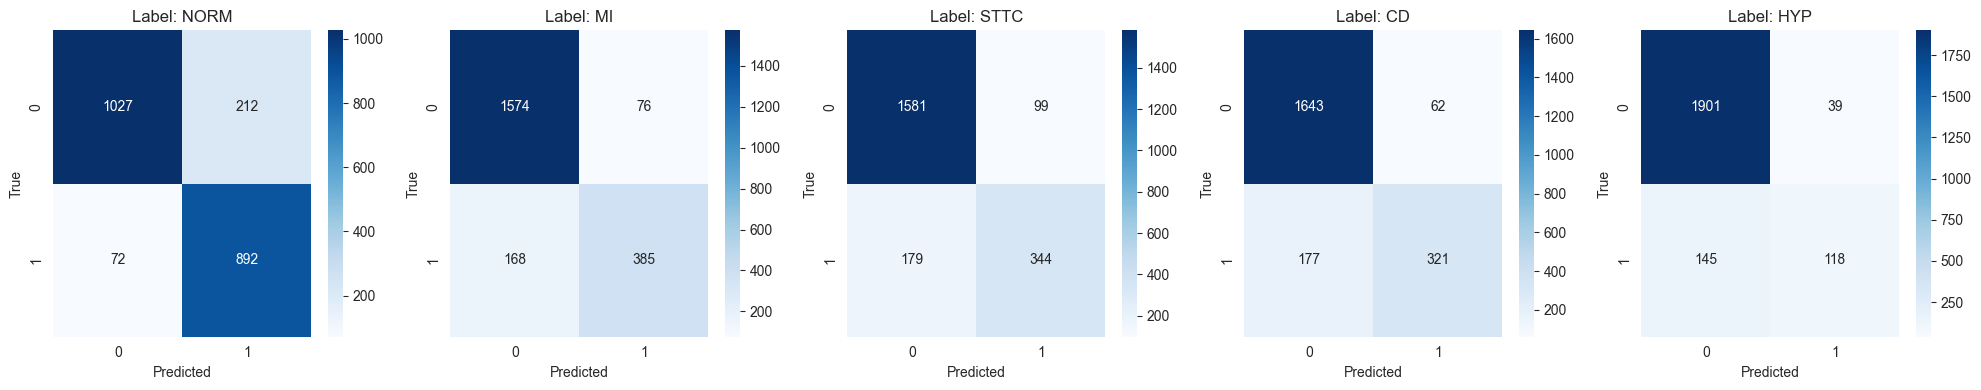

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix


conf_matrices = multilabel_confusion_matrix(Z_test, Z_pred)
labels = Z.columns  # tên nhãn: ['NORM', 'MI', 'STTC', 'CD', 'HYP']


fig, axes = plt.subplots(1, 5, figsize=(20, 4)) 

for i in range(5):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.show()
